# Ad Hoh в Skytaxi


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings('ignore')

## Чтение и первичный анализ данных

In [3]:
DS = pd.read_csv('D:/Program Files (x86)/skypro/Бизнес блок/Кейс 1/Data_Skytaxi.csv', sep=';')
df_city = pd.read_csv('D:/Program Files (x86)/skypro/Бизнес блок/Кейс 1/city_dict.csv', sep=';')
df_tariff = pd.read_csv('D:/Program Files (x86)/skypro/Бизнес блок/Кейс 1/tariff_dict.csv', sep=';')

In [4]:
DS.head()

,order_id,id_tariff,id_city,order_time,assign_time,arrive_time,ride_finish_time
0,1146020,111,13,04.08.2022 7:12,NaN,NaN,NaN
1,1146340,114,11,02.08.2022 19:12,02.08.2022 19:19,02.08.2022 19:26,02.08.2022 19:50
2,1142747,112,13,01.08.2022 13:47,01.08.2022 13:53,01.08.2022 13:59,01.08.2022 14:16
3,1137227,111,17,03.08.2022 15:45,NaN,NaN,NaN
4,1137156,111,13,02.08.2022 15:00,02.08.2022 15:02,02.08.2022 15:11,02.08.2022 15:26


In [5]:
DS = DS.merge(df_city, on = 'id_city')
DS = DS.merge(df_tariff, on = 'id_tariff')

In [6]:
for i in ['order_time', 'assign_time', 'arrive_time', 'ride_finish_time']:
    DS[i] = DS[i].apply(pd.to_datetime)

In [7]:
DS.describe(include='all')

,order_id,id_tariff,id_city,order_time,assign_time,arrive_time,ride_finish_time,name_city,name_tariff
count,1.002000e+04,10020.000000,10020.000000,10020,6743,5345,4834,10020,10020
unique,NaN,NaN,NaN,4050,3717,3488,3381,9,5
top,NaN,NaN,NaN,2022-05-08 20:38:00,2022-02-08 20:44:00,2022-01-08 18:39:00,2022-02-08 07:46:00,Москва,Эконом
freq,NaN,NaN,NaN,51,14,8,6,3111,4298
first,NaN,NaN,NaN,2022-01-08 00:00:00,2022-01-08 00:04:00,2022-01-08 00:07:00,2022-01-08 00:31:00,NaN,NaN
last,NaN,NaN,NaN,2022-07-08 23:59:00,2022-08-08 00:00:00,2022-08-08 00:03:00,2022-08-08 00:12:00,NaN,NaN
mean,1.141859e+06,112.172355,13.465269,NaN,NaN,NaN,NaN,NaN,NaN
std,2.958396e+03,1.292115,2.592320,NaN,NaN,NaN,NaN,NaN,NaN
min,1.136741e+06,111.000000,11.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.139294e+06,111.000000,11.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
DS['hour'] = DS['order_time'].dt.hour
DS['peak'] = np.where(DS['hour'].isin([7, 8, 9, 10, 17, 18, 19, 20]), 1, 0)

In [11]:
DS_gr = DS.groupby(['peak']).count()[['order_time']].reset_index()
DS_gr_city = DS.groupby(['peak', 'name_city']).count()[['order_time']].reset_index()

In [12]:
DS_gr_city

,peak,name_city,order_time
0,0,Екатеринбург,199
1,0,Казань,301
2,0,Краснодар,239
3,0,Красноярск,172
4,0,Москва,1099
5,0,Новосибирск,274
6,0,Санкт-Петербург,748
7,0,Тюмень,226
8,0,Хабаровск,209
9,1,Екатеринбург,383


<BarContainer object of 24 artists>

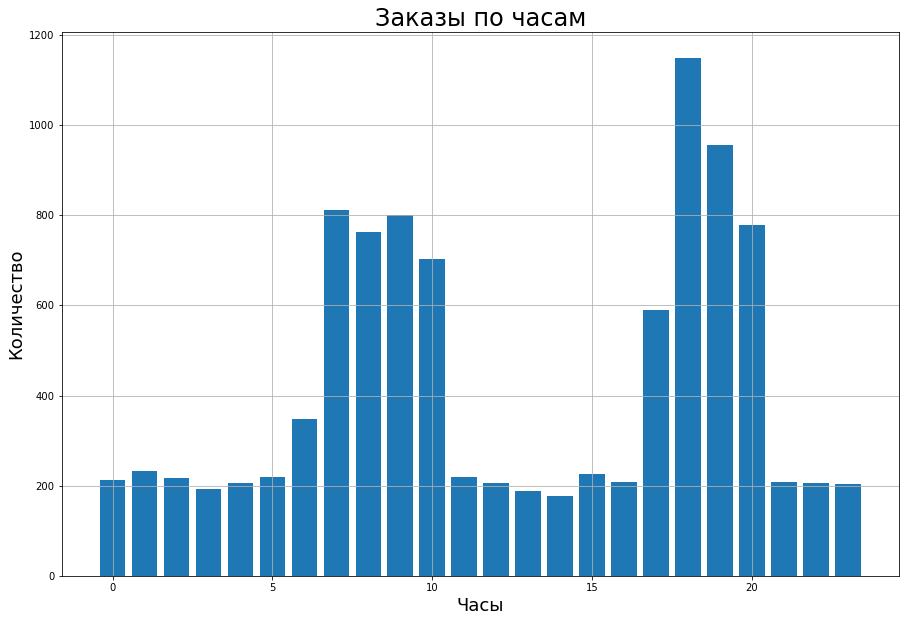

In [14]:
DS_graph = DS.groupby(['hour']).count()['order_time'].reset_index()

plt.figure(figsize=(15,10))
plt.grid()
plt.title('Заказы по часам', size='24')
plt.xlabel('Часы', size='18')
plt.ylabel('Количество', size='18')
plt.bar(DS_graph['hour'], DS_graph['order_time'])

In [18]:
DS_gr['orders_by_hour'] = np.where(DS_gr['peak'] == 0, DS_gr['order_time'] / 16, DS_gr['order_time'] / 8)
DS_gr_city['orders_by_hour'] = np.where(DS_gr_city['peak'] == 0, DS_gr_city['order_time'] / 16, DS_gr_city['order_time'] / 8)

In [21]:
DS_cities = pd.DataFrame({'city': DS_gr_city['name_city'].unique()})

def diff(i):
    return DS_gr_city[(DS_gr_city['peak'] == 1) & (DS_gr_city['name_city'] == i)]['orders_by_hour'].item() \
          - DS_gr_city[(DS_gr_city['peak'] == 0) & (DS_gr_city['name_city'] == i)]['orders_by_hour'].item()  

In [22]:
DS_cities['diff_hour'] = DS_cities['city'].map(diff)  

In [23]:
DS_cities 

,city,diff_hour
0,Екатеринбург,35.4375
1,Казань,56.9375
2,Краснодар,46.9375
3,Красноярск,30.6250
4,Москва,182.8125
5,Новосибирск,54.5000
6,Санкт-Петербург,119.7500
7,Тюмень,36.6250
8,Хабаровск,38.8125


In [25]:
df_o2r = DS.groupby(['peak', 'name_city']).count()[['order_time', 'ride_finish_time']].reset_index()
df_o2r['o2r'] = df_o2r['ride_finish_time'] / df_o2r['order_time']

In [26]:
df_o2r

,peak,name_city,order_time,ride_finish_time,o2r
0,0,Екатеринбург,199,113,0.567839
1,0,Казань,301,173,0.574751
2,0,Краснодар,239,145,0.606695
3,0,Красноярск,172,60,0.348837
4,0,Москва,1099,615,0.559600
5,0,Новосибирск,274,166,0.605839
6,0,Санкт-Петербург,748,416,0.556150
7,0,Тюмень,226,61,0.269912
8,0,Хабаровск,209,46,0.220096
9,1,Екатеринбург,383,220,0.574413


In [33]:
def diff_conv(i):
    return abs(df_o2r[(df_o2r['peak'] == 1) & (df_o2r['name_city'] == i)]['o2r'].item() \
          - df_o2r[(df_o2r['peak'] == 0) & (df_o2r['name_city'] == i)]['o2r'].item())

In [34]:
DS_cities['diff_conver'] = DS_cities['city'].map(diff_conv)

In [37]:
DS_cities.set_index('city') \
     .style.format('{:.3f}')\
     .background_gradient(cmap='Reds', axis=0, subset=['diff_hour'])\
     .highlight_max(color='red', axis=0, subset=['diff_conver'])

,diff_hour,diff_conver
city,,
Екатеринбург,35.438,0.007
Казань,56.938,0.025
Краснодар,46.938,0.035
Красноярск,30.625,0.059
Москва,182.812,0.117
Новосибирск,54.500,0.021
Санкт-Петербург,119.750,0.093
Тюмень,36.625,0.004
Хабаровск,38.812,0.064


In [38]:
DS['new_city'] = np.where(DS['name_city'].isin(['Тюмень', 'Хабаровск']), 1, 0)

In [42]:
df_gr = DS.groupby('new_city').count()[['order_time', 'assign_time', 'arrive_time', 'ride_finish_time']].reset_index()

In [43]:
df_gr['o2ar'] = df_gr['assign_time']      / df_gr['order_time']
df_gr['a2as'] = df_gr['arrive_time']      / df_gr['assign_time']
df_gr['ar2r'] = df_gr['ride_finish_time'] / df_gr['arrive_time']
df_gr['o2r']  = df_gr['ride_finish_time'] / df_gr['order_time']

In [44]:
df_gr

,new_city,order_time,assign_time,arrive_time,ride_finish_time,o2ar,a2as,ar2r,o2r
0,0,8764,6178,4877,4501,0.704929,0.789414,0.922903,0.513578
1,1,1256,565,468,333,0.449841,0.828319,0.711538,0.265127


In [45]:
df_gr[df_gr['new_city'] == 0]['o2r'].item() - df_gr[df_gr['new_city'] == 1]['o2r'].item()

0.24845088622535155

In [46]:
DS['new_city2'] = np.where(DS['name_city'].isin(['Тюмень', 'Хабаровск']), DS['name_city'], 'Other')

In [47]:
df_gr1 = DS.groupby('new_city2').count()[['order_time', 'assign_time', 'arrive_time', 'ride_finish_time']].reset_index()

In [49]:
df_gr1['o2ar'] = df_gr1['assign_time']      / df_gr1['order_time']
df_gr1['a2as'] = df_gr1['arrive_time']      / df_gr1['assign_time']
df_gr1['ar2r'] = df_gr1['ride_finish_time'] / df_gr1['arrive_time']
df_gr1['o2r']  = df_gr1['ride_finish_time'] / df_gr1['order_time']

In [50]:
df_gr1

,new_city2,order_time,assign_time,arrive_time,ride_finish_time,o2ar,a2as,ar2r,o2r
0,Other,8764,6178,4877,4501,0.704929,0.789414,0.922903,0.513578
1,Тюмень,632,352,295,169,0.556962,0.838068,0.572881,0.267405
2,Хабаровск,624,213,173,164,0.341346,0.812207,0.947977,0.262821


In [51]:
df_gr2 = DS.groupby(['name_city']).count()[['arrive_time', 'ride_finish_time']].reset_index()

In [52]:
df_gr2['arr2r'] = df_gr2['ride_finish_time'] / df_gr2['arrive_time']

In [53]:
df_gr2.style.background_gradient(cmap='Blues', axis=0, subset='arr2r')

,name_city,arrive_time,ride_finish_time,arr2r
0,Екатеринбург,354,333,0.940678
1,Казань,528,506,0.958333
2,Краснодар,457,428,0.936543
3,Красноярск,320,195,0.609375
4,Москва,1594,1505,0.944166
5,Новосибирск,525,501,0.954286
6,Санкт-Петербург,1099,1033,0.939945
7,Тюмень,295,169,0.572881
8,Хабаровск,173,164,0.947977


In [59]:
df_de = DS[DS['name_tariff'] == 'Доставка']

In [55]:
df_de['name_city'].value_counts(normalize=True)

Москва             0.335878
Санкт-Петербург    0.209160
Новосибирск        0.099237
Казань             0.083969
Екатеринбург       0.071756
Хабаровск          0.071756
Тюмень             0.067176
Красноярск         0.058015
Краснодар          0.003053
Name: name_city, dtype: float64

In [60]:
df_de = df_de[df_de['name_city'] != 'Краснодар']

In [61]:
df_de.head()

,order_id,id_tariff,id_city,order_time,assign_time,arrive_time,ride_finish_time,name_city,name_tariff,hour,peak,new_city,new_city2
9365,1140485,115,13,2022-04-08 08:30:00,NaT,NaT,NaT,Казань,Доставка,8,1,0,Other
9366,1143658,115,13,2022-05-08 07:12:00,NaT,NaT,NaT,Казань,Доставка,7,1,0,Other
9367,1146695,115,13,2022-03-08 18:28:00,2022-03-08 18:32:00,2022-03-08 18:51:00,2022-03-08 19:04:00,Казань,Доставка,18,1,0,Other
9368,1146342,115,13,2022-07-08 07:46:00,2022-07-08 07:51:00,2022-07-08 08:11:00,2022-07-08 08:22:00,Казань,Доставка,7,1,0,Other
9369,1146481,115,13,2022-03-08 10:33:00,2022-03-08 10:37:00,NaT,NaT,Казань,Доставка,10,1,0,Other


In [62]:
df_de_gr = df_de.groupby('name_city').count()[['order_time','assign_time','arrive_time','ride_finish_time']].reset_index()

df_de_gr['o2ass']       = df_de_gr['assign_time']      / df_de_gr['order_time']
df_de_gr['ass2arr']     = df_de_gr['arrive_time']      / df_de_gr['assign_time']
df_de_gr['arr2r']       = df_de_gr['ride_finish_time'] / df_de_gr['arrive_time']
df_de_gr['o2r']         = df_de_gr['ride_finish_time'] / df_de_gr['order_time']

In [63]:
df_de_gr['o2r_upper']     = df_de_gr['o2r'] + 1.96 * (df_de_gr['o2r'] * (1-df_de_gr['o2r']) / df_de_gr['order_time']).apply(np.sqrt)
df_de_gr['o2r_lower']     = df_de_gr['o2r'] - 1.96 * (df_de_gr['o2r'] * (1-df_de_gr['o2r']) / df_de_gr['order_time']).apply(np.sqrt)

df_de_gr['o2ass_upper']   = df_de_gr['o2ass'] + 1.96 * (df_de_gr['o2ass'] * (1-df_de_gr['o2ass']) / df_de_gr['order_time']).apply(np.sqrt)
df_de_gr['o2ass_lower']   = df_de_gr['o2ass'] - 1.96 * (df_de_gr['o2ass'] * (1-df_de_gr['o2ass']) / df_de_gr['order_time']).apply(np.sqrt)

df_de_gr['ass2arr_upper'] = df_de_gr['ass2arr'] + 1.96 * (df_de_gr['ass2arr'] * (1-df_de_gr['ass2arr']) / df_de_gr['assign_time']).apply(np.sqrt)
df_de_gr['ass2arr_lower'] = df_de_gr['ass2arr'] - 1.96 * (df_de_gr['ass2arr'] * (1-df_de_gr['ass2arr']) / df_de_gr['assign_time']).apply(np.sqrt)

df_de_gr['arr2r_upper']   = df_de_gr['arr2r'] + 1.96 * (df_de_gr['arr2r'] * (1-df_de_gr['arr2r']) / df_de_gr['arrive_time']).apply(np.sqrt)
df_de_gr['arr2r_lower']   = df_de_gr['arr2r'] - 1.96 * (df_de_gr['arr2r'] * (1-df_de_gr['arr2r']) / df_de_gr['arrive_time']).apply(np.sqrt)

In [64]:
df_de_gr

,name_city,order_time,assign_time,arrive_time,ride_finish_time,o2ass,ass2arr,arr2r,o2r,o2r_upper,o2r_lower,o2ass_upper,o2ass_lower,ass2arr_upper,ass2arr_lower,arr2r_upper,arr2r_lower
0,Екатеринбург,47,37,31,28,0.787234,0.837838,0.903226,0.595745,0.736047,0.455442,0.904241,0.670228,0.956609,0.719067,1.007302,0.799149
1,Казань,55,42,34,33,0.763636,0.809524,0.970588,0.600000,0.729473,0.470527,0.875918,0.651355,0.928283,0.690765,1.027381,0.913795
2,Красноярск,38,31,25,18,0.815789,0.806452,0.720000,0.473684,0.632441,0.314928,0.939046,0.692533,0.945530,0.667373,0.896008,0.543992
3,Москва,220,155,118,112,0.704545,0.761290,0.949153,0.509091,0.575152,0.443030,0.764835,0.644256,0.828402,0.694178,0.988791,0.909514
4,Новосибирск,65,43,39,38,0.661538,0.906977,0.974359,0.584615,0.704416,0.464815,0.776574,0.546503,0.993796,0.820158,1.023967,0.924751
5,Санкт-Петербург,137,100,74,70,0.729927,0.740000,0.945946,0.510949,0.594656,0.427242,0.804276,0.655578,0.825972,0.654028,0.997467,0.894425
6,Тюмень,44,11,8,7,0.250000,0.727273,0.875000,0.159091,0.267166,0.051015,0.377947,0.122053,0.990465,0.464081,1.104177,0.645823
7,Хабаровск,47,16,12,11,0.340426,0.750000,0.916667,0.234043,0.355090,0.112995,0.475898,0.204953,0.962176,0.537824,1.073046,0.760287


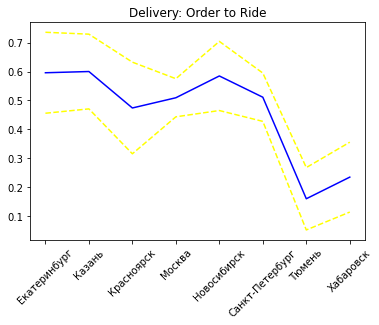

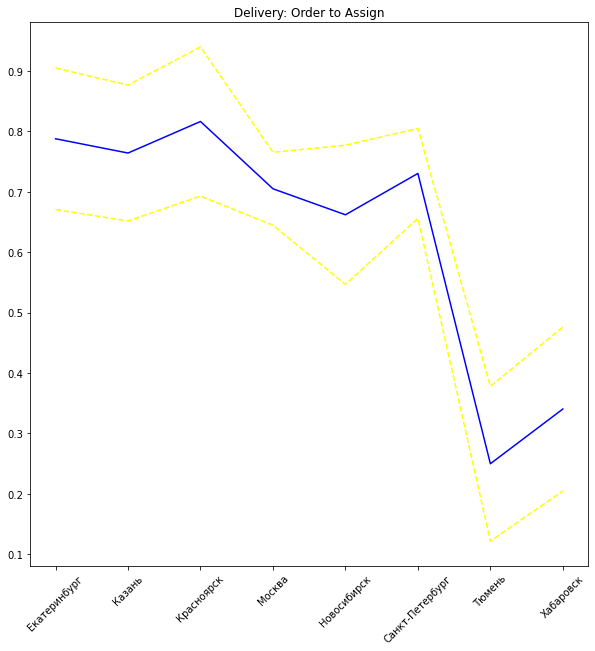

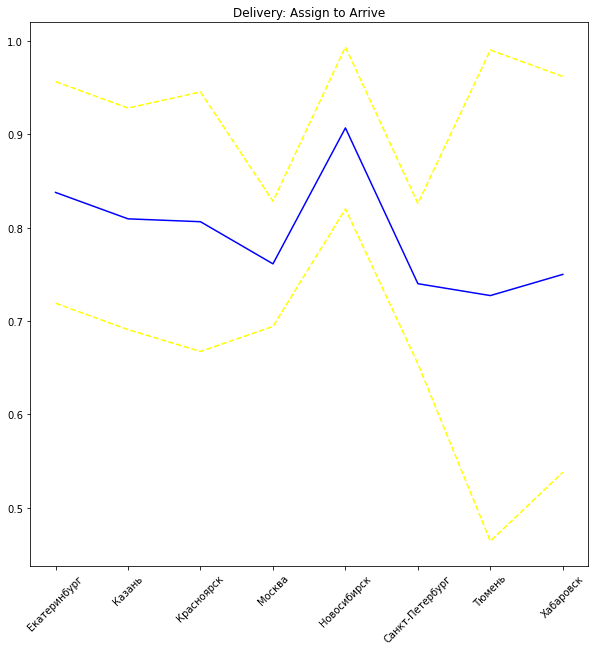

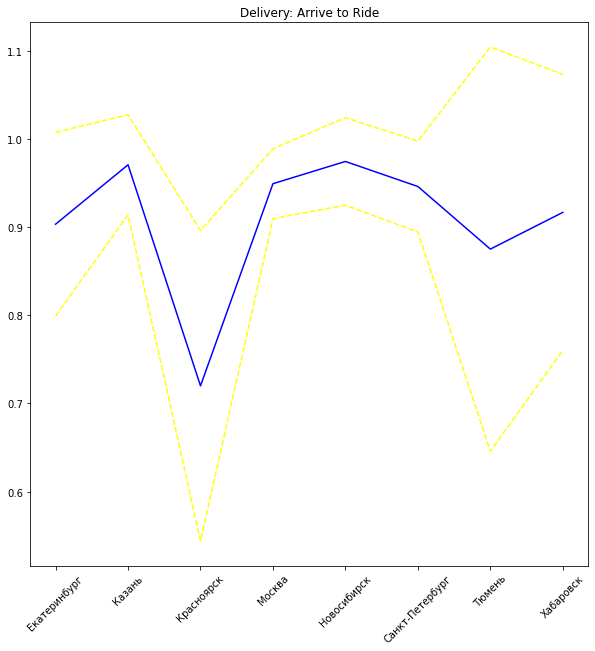

In [65]:
plt.figure()
plt.rcParams["figure.figsize"] = (10,10)

steps = {'o2r': 'Order to Ride', 'o2ass':'Order to Assign', 'ass2arr':'Assign to Arrive', 'arr2r':'Arrive to Ride'}
for col in steps.keys():
    plt.plot(df_de_gr['name_city'], df_de_gr[col], color = 'blue')
    plt.plot(df_de_gr['name_city'], df_de_gr[f'{col}_upper'], color = 'yellow', linestyle='--')
    plt.plot(df_de_gr['name_city'], df_de_gr[f'{col}_lower'], color = 'yellow', linestyle='--')
    plt.xticks(rotation=45)
    plt.title(f'Delivery: {steps[col]}')
    plt.show()